# Word Network Graph

Created 2023-01-21

Peter Leimbigler

Let's visualize English words as nodes in an undirected network graph. Two words are linked if their edit distance (e.g., Levenshtein distance) is 1.

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
# To add white border to label text
import matplotlib.patheffects as path_effects

from Levenshtein import distance
import networkx as nx

In [2]:
plt.rcParams['figure.facecolor'] = 'w'
%config InlineBackend.figure_format = 'retina'

## Spot checks

In [3]:
# Expect 2
distance('transposition', 'tarnsposition')

2

In [4]:
# Expect 4
distance('abcd', 'dcba')

4

In [5]:
# Expect score_cutoff + 1
distance('wildly different', 'strings', score_cutoff=1)

2

## Read Dictionary Words

In [6]:
words = []
with open('/usr/share/dict/words', 'r') as f:
    words = f.read().split()

In [7]:
len(words)

235886

In [8]:
random.seed(1)
print(random.sample(words, 10))

['choler', 'pneumodynamics', 'unrulableness', 'ultimateness', 'terebinthina', 'avast', 'expellable', 'carpogone', 'odontoloxia', 'teleost']


In [9]:
# Aside: what sorts of words in this dictionary start with capital letter?
upper_words = [w for w in words if w[0] == w[0].upper()]
len(upper_words)

25199

In [10]:
random.seed(1)
print(random.sample(upper_words, 50))

['Cariamae', 'Productidae', 'Zarathustrism', 'Arnaut', 'Falunian', 'Bulgar', 'Ods', 'Yquem', 'Milo', 'Nachitoch', 'Sminthurus', 'Kuneste', 'Diaspora', 'Bembex', 'Norbertine', 'Alpheratz', 'Leguatia', 'Mayance', 'Sabiaceae', 'Zachariah', 'Zoophagineae', 'Absalom', 'Tetum', 'Metoac', 'Frimaire', 'Tullian', 'Edentata', 'Restionaceae', 'Blemmyes', 'Hibernian', 'Amarantus', 'Alcibiadean', 'Alibamu', 'Skeltonical', 'Philonism', 'Adamite', 'Laburnum', 'Targumist', 'Discina', 'Malurinae', 'Tylerize', 'Altaic', 'Pegasidae', 'Draconis', 'Zaramo', 'Melanodendron', 'Oedipus', 'Plataleidae', 'Elizabeth', 'Islamist']


In [11]:
# Create a pandas Series for descriptive stats
s = pd.Series(words)

In [12]:
# How many megabytes does this series occupy, anyway?
s.nbytes / 2**20

1.7996673583984375

In [13]:
lens = s.str.len().value_counts().sort_index()
lens

1        52
2       160
3      1420
4      5272
5     10230
6     17706
7     23869
8     29989
9     32403
10    30878
11    26013
12    20462
13    14939
14     9765
15     5925
16     3377
17     1813
18      842
19      428
20      198
21       82
22       41
23       17
24        5
dtype: int64

**Observations**

- 26 1-letter words: the dictionary file includes the lowercase and uppercase versions of each letter of the alphabet.
- Five words share the longest word length in this dictionary of 24.

In [14]:
# What are those five 24-letter words in the OSX dictionary, anyway?
s[s.str.len() == 24]

72631     formaldehydesulphoxylate
140338    pathologicopsychological
175107    scientificophilosophical
200795    tetraiodophenolphthalein
203041    thyroparathyroidectomize
dtype: object

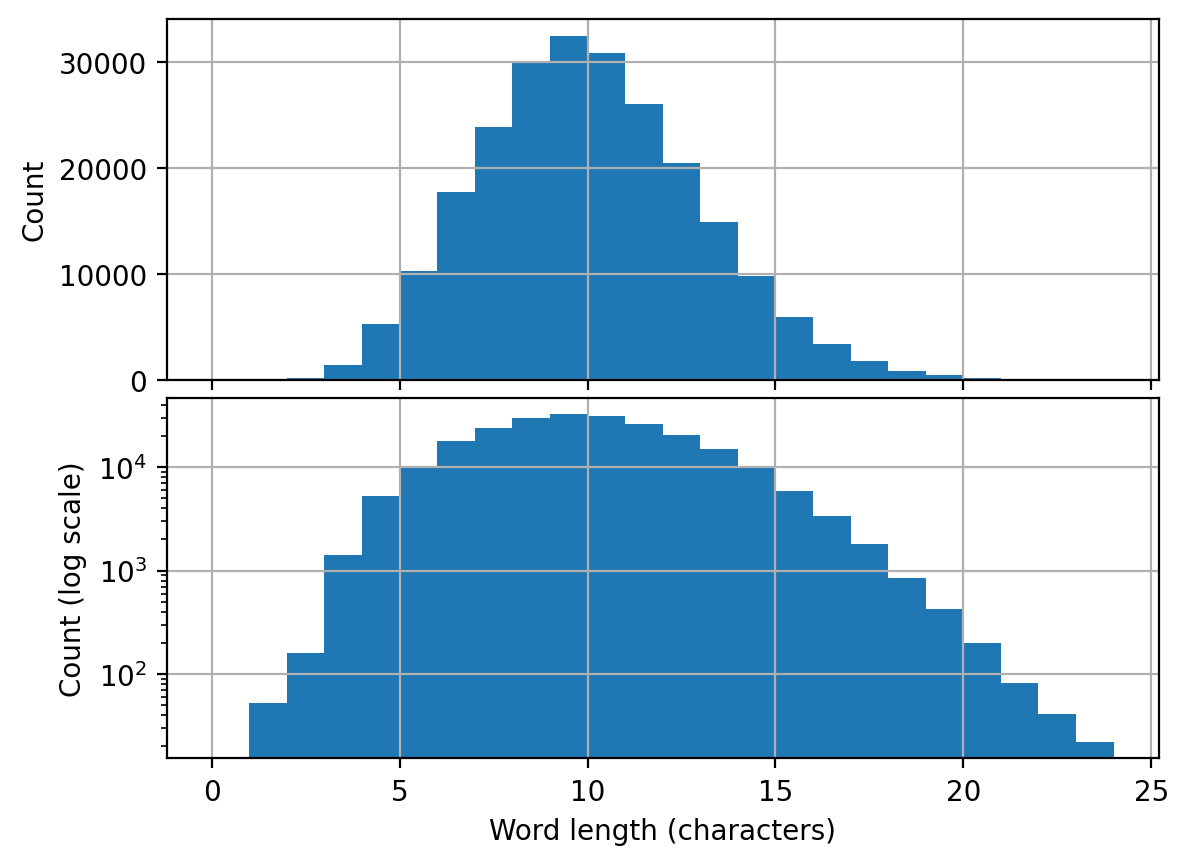

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True)
s.str.len().hist(ax=ax[0], bins=range(25))
s.str.len().hist(ax=ax[1], bins=range(25), log=True)

# https://stackoverflow.com/a/22608025
fig.subplots_adjust(hspace=0.05)

ax[0].set(ylabel='Count')
ax[1].set(xlabel='Word length (characters)', ylabel='Count (log scale)');

## Judgment call: discard words with uppercase first letter

In [16]:
print(f'{len(s)=:,}')
s = s[s.str[0] == s.str[0].str.lower()].reset_index(drop=True)
print(f'{len(s)=:,}')

len(s)=235,886
len(s)=210,687


## Given a word, get words with Levenshtein Distance of 1

Recursively expand the graph of distance-1 words to a specified search "depth."

In [17]:
# Build an adjacency graph from a starting word, out to a given search depth
def build_graph(word, depth=1):
    
    edges = []
    deeper_edges = []
    # FIXME: seems incredibly wasteful to create a new series of candidate words
    # with every depth level. But it *does* run.
    candidate_words = s[s.str.len().between(len(word) - 1, len(word) + 1)]
    
    for other_word in candidate_words:
        if distance(word.lower(), other_word.lower(), score_cutoff=1) == 1:
            edges.append([word, other_word, depth])
            if depth > 1:
                edges += build_graph(other_word, depth - 1)
        
    return edges

## Build graph for a given word and depth

In [18]:
word = 'lobster'
depth = 3

In [19]:
edges = pd.DataFrame(build_graph(word, depth), 
                     columns=['source', 'target', 'depth'])

In [20]:
# Hack: eliminate potential cycles by keeping the highest depth value
# for each word pair
edges = edges.groupby(['source', 'target'], as_index=False)['depth'].max()

In [21]:
edges.shape

(82, 3)

In [22]:
edges.head()

,source,target,depth
0,jouster,louster,1
1,jouster,ouster,1
2,jouster,rouster,1
3,lobster,louster,3
4,lobster,mobster,3


## Build network graph

In [23]:
# Limit depth in static visualization
max_render_depth = 2
G = nx.from_pandas_edgelist(edges[edges['depth'] >= depth - max_render_depth], edge_attr=['depth'])

In [24]:
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl_colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

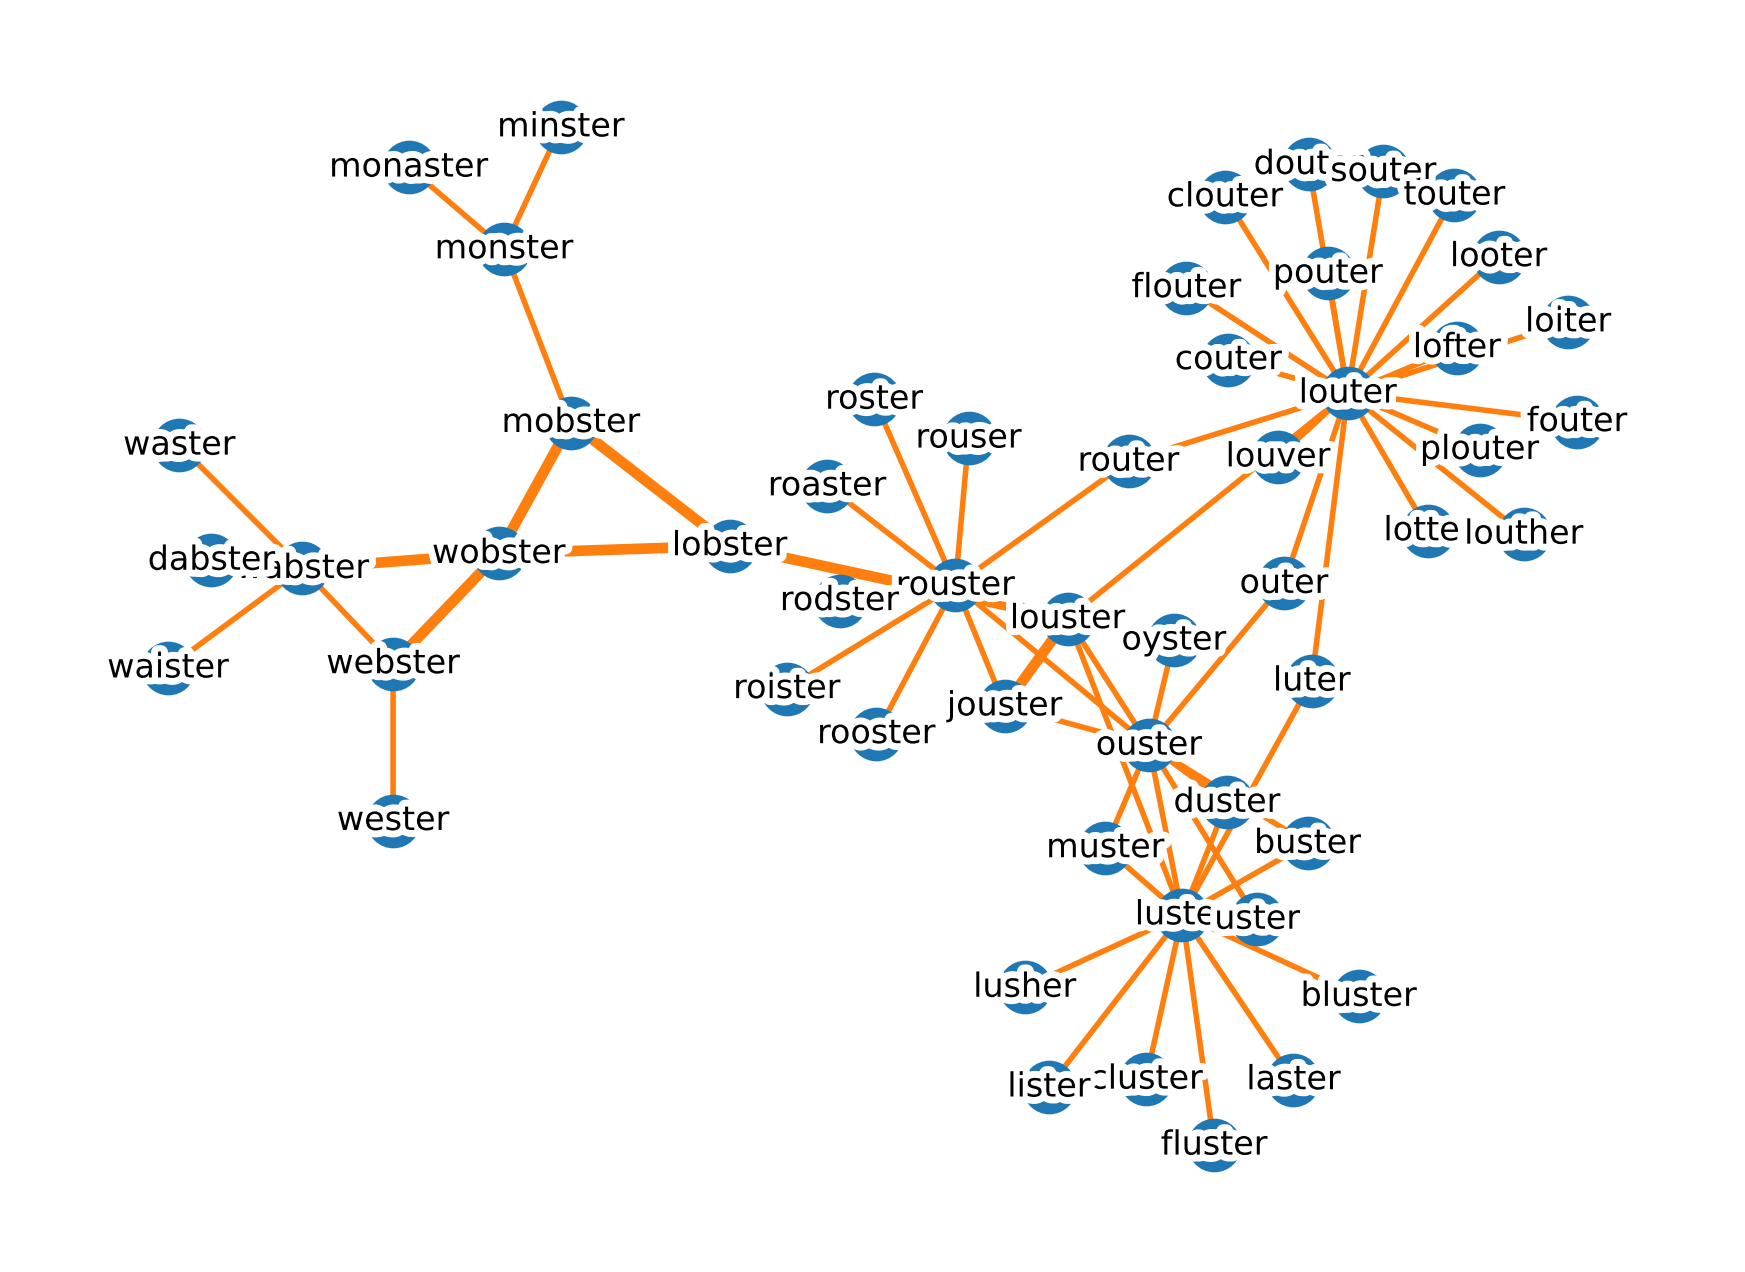

In [25]:
# Available programs: 'neato', 'dot', 'twopi', 'fdp', 'sfdp', 'circo'
pos = nx.nx_agraph.graphviz_layout(G, 'sfdp')

# pos = nx.spring_layout(G, k=3/(len(G)**.5), weight='depth')

fig, ax = plt.subplots(figsize=(11, 8))
ax.axis('off')

# Nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=mpl_colors[0],
    linewidths=2,
    ax=ax
)

# Node text labels
node_label_handles = nx.draw_networkx_labels(G, pos=pos, ax=ax);

# Visualize network distance from given word as thicker edges
# that get thinner as you move outward
linewidths = [1 + G[u][v]['depth']**1.5 for u, v in G.edges()]

# Draw edges and store the returned FancyArrowPatch list
arrowheads = nx.draw_networkx_edges(
    G,
    pos,
    edge_color=mpl_colors[1],
    width=linewidths,
    ax=ax
)

# Add white outline to text
for t in node_label_handles.values():
    t.set_path_effects([path_effects.Stroke(linewidth=5, 
                                            foreground='white'),
                       path_effects.Normal()])

## Write nodes and links to file for `3d-force-graph`

In [26]:
import json

In [27]:
nodes = (
    pd.concat([edges['source'], edges['target']], axis=0)
      .rename('id')
      .drop_duplicates()
      .to_frame()
      .to_dict(orient='records')
)

In [28]:
nodes[:5]

[{'id': 'jouster'},
 {'id': 'lobster'},
 {'id': 'louster'},
 {'id': 'louter'},
 {'id': 'luster'}]

In [29]:
links = edges.to_dict(orient='records')

In [30]:
links[:5]

[{'source': 'jouster', 'target': 'louster', 'depth': 1},
 {'source': 'jouster', 'target': 'ouster', 'depth': 1},
 {'source': 'jouster', 'target': 'rouster', 'depth': 1},
 {'source': 'lobster', 'target': 'louster', 'depth': 3},
 {'source': 'lobster', 'target': 'mobster', 'depth': 3}]

In [31]:
output_json = {'nodes': nodes, 'links': links}

In [32]:
output_text = 'var data = ' + json.dumps(output_json) + ';'

In [33]:
with open('data.js', 'w') as f:
    f.write(output_text)